# Word Embedding Approach

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModel
import torch
from torch.nn.functional import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage

c:\Users\Leo\miniconda3\envs\wise-dag-ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dag_df = pd.read_csv('../data/DAGs_standardized.csv', dtype={'Exposure': str, 'Outcome':str})
concept_df = pd.read_csv('../Standardization/athena_vocabulary/CONCEPT.csv', sep='\t', dtype={'concept_code': str, 'concept_id': str}, low_memory=False)

In [3]:
my_term_codes = set(dag_df[
    dag_df.Exposure.str.isdigit() & dag_df.Outcome.str.isdigit()]['Exposure']
    ).union(set(dag_df[dag_df.Exposure.str.isdigit() & dag_df.Outcome.str.isdigit()]['Outcome']))

In [30]:
code_to_name = dict(zip(concept_df["concept_id"], concept_df["concept_name"]))
name_to_code = dict(zip(concept_df["concept_name"], concept_df["concept_id"]))

In [32]:
my_terms = [code_to_name[i] for i in sorted(my_term_codes)]

In [33]:
# my_terms = [term.lower() for term in my_terms]
# my_terms = [re.sub(r'[^a-zA-Z0-9\s]', ' ', term) for term in my_terms]
# my_terms = [re.sub(r'\s+', ' ', term).strip() for term in my_terms]

### Getting Embeddings

In [34]:
# model_name = "KimTang/SNOMEDCT_BioBERT"
model_name = "cambridgeltl/SapBERT-from-PubMedBERT-fulltext"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [35]:
def get_embeddings(terms):
    embeddings = {}
    for term in terms:
        inputs = tokenizer(term, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        # Extract [CLS] token embedding
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0)
        embeddings[term] = cls_embedding
    return embeddings

embeddings = get_embeddings(my_terms)
embedding_name = list(embeddings.keys())
embedding_matrix = torch.stack(list(embeddings.values())).numpy()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Check if sufficient variance in embeddings (should not be very close to 0)

In [36]:
np.mean(np.var(embedding_matrix, axis=0))

0.23167264

Check example similarity calculations

In [37]:
cosine_similarity(
    embeddings['Hypercholesterolemia'].unsqueeze(0), embeddings['Hyperlipidemia'].unsqueeze(0)
).item()

0.8836954832077026

In [38]:
cosine_similarity(
    embeddings['Lipoprotein (a) measurement'].unsqueeze(0), embeddings['Hyperlipidemia'].unsqueeze(0)
).item()

0.5778646469116211

In [39]:
cosine_similarity(
    embeddings['Infectious disease'].unsqueeze(0), embeddings['COVID-19'].unsqueeze(0)
).item()

0.38932478427886963

In [40]:
cosine_similarity(
    embeddings['Diabetes mellitus'].unsqueeze(0), embeddings['Blood glucose level - finding'].unsqueeze(0)
).item()

0.38683152198791504

In [41]:
cosine_similarity(
    embeddings['Healthy diet'].unsqueeze(0), embeddings['Low sodium diet'].unsqueeze(0)
).item()

0.5041983127593994

In [42]:
cosine_similarity(
    embeddings['Mediterranean diet'].unsqueeze(0), embeddings['Healthy diet'].unsqueeze(0)
).item()

0.6994273662567139

Show graphically in reduced dimension

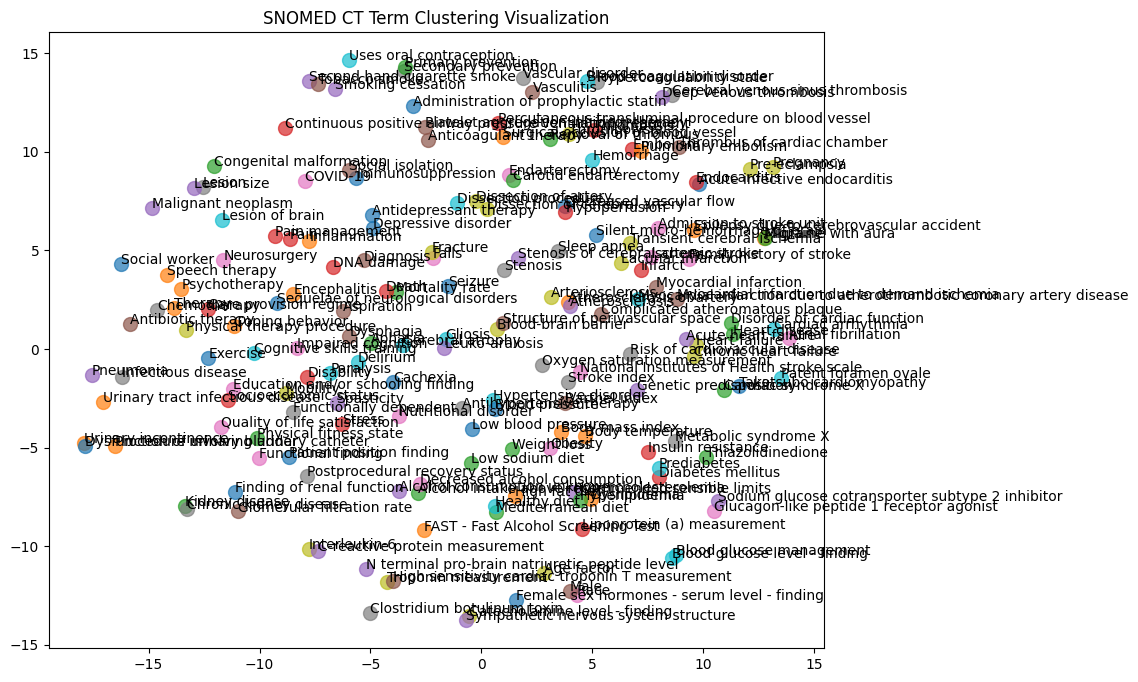

In [43]:
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embedding_matrix)

# Plot clusters
plt.figure(figsize=(10, 8))
for i, term in enumerate(embeddings.keys()):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label=term, alpha=0.7, s=100)
    plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], term, fontsize=10)
plt.title("SNOMED CT Term Clustering Visualization");

In [44]:
embedding_similarity_matrix = cosine_similarity(embedding_matrix)

In [47]:
similarity_df = pd.DataFrame(embedding_similarity_matrix, index=sorted(my_term_codes), columns=sorted(my_term_codes))
similarity_df

,134765,197672,198124,201820,255848,31317,313217,313459,316139,316866,...,44800078,44803656,44804450,44805124,46270002,46271022,46272492,604179,606770,81902
134765,1.000000,0.366477,0.298828,0.369906,0.321235,0.547029,0.326551,0.374053,0.553298,0.217801,...,0.382121,0.302695,0.362562,0.315157,0.414628,0.400116,0.255518,0.240170,0.174649,0.203110
197672,0.366477,1.000000,0.299005,0.257105,0.242415,0.329265,0.317649,0.341924,0.334019,0.241831,...,0.243599,0.260811,0.251183,0.174980,0.275174,0.288321,0.100158,0.185004,0.256965,0.533248
198124,0.298828,0.299005,1.000000,0.446783,0.362288,0.221745,0.159015,0.166188,0.400349,0.359231,...,0.296612,0.222971,0.170376,0.157289,0.203627,0.764325,0.186148,0.161856,0.556062,0.488472
201820,0.369906,0.257105,0.446783,1.000000,0.259304,0.352574,0.307616,0.277796,0.345381,0.363420,...,0.327209,0.260049,0.297709,0.229288,0.182654,0.454228,0.358792,0.236249,0.180678,0.273723
255848,0.321235,0.242415,0.362288,0.259304,1.000000,0.327758,0.224481,0.313170,0.293004,0.222915,...,0.277825,0.207809,0.321831,0.184532,0.231279,0.289172,0.176974,0.169953,0.224184,0.498599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46271022,0.400116,0.288321,0.764325,0.454228,0.289172,0.244393,0.227001,0.233698,0.474393,0.279905,...,0.309768,0.307510,0.301068,0.255903,0.262213,1.000000,0.191420,0.315902,0.490721,0.331447
46272492,0.255518,0.100158,0.186148,0.358792,0.176974,0.269226,0.212862,0.273654,0.228038,0.291881,...,0.152633,0.176243,0.258354,0.278094,0.228979,0.191420,1.000000,0.401222,0.029932,0.118660
604179,0.240170,0.185004,0.161856,0.236249,0.169953,0.245037,0.279803,0.256800,0.397241,0.268314,...,0.223268,0.169606,0.256903,0.381608,0.155043,0.315902,0.401222,1.000000,0.053872,0.158446
606770,0.174649,0.256965,0.556062,0.180678,0.224184,0.126850,0.215382,0.113786,0.359359,0.147615,...,0.439056,0.160333,0.096930,0.089414,0.167049,0.490721,0.029932,0.053872,1.000000,0.254819


In [49]:
similarity_df.to_csv('embedding_similarity_matrix.csv')

### Clustering

In [104]:
linkage_matrix = linkage(embedding_matrix, method='ward')

Text(0, 0.5, 'Distance')

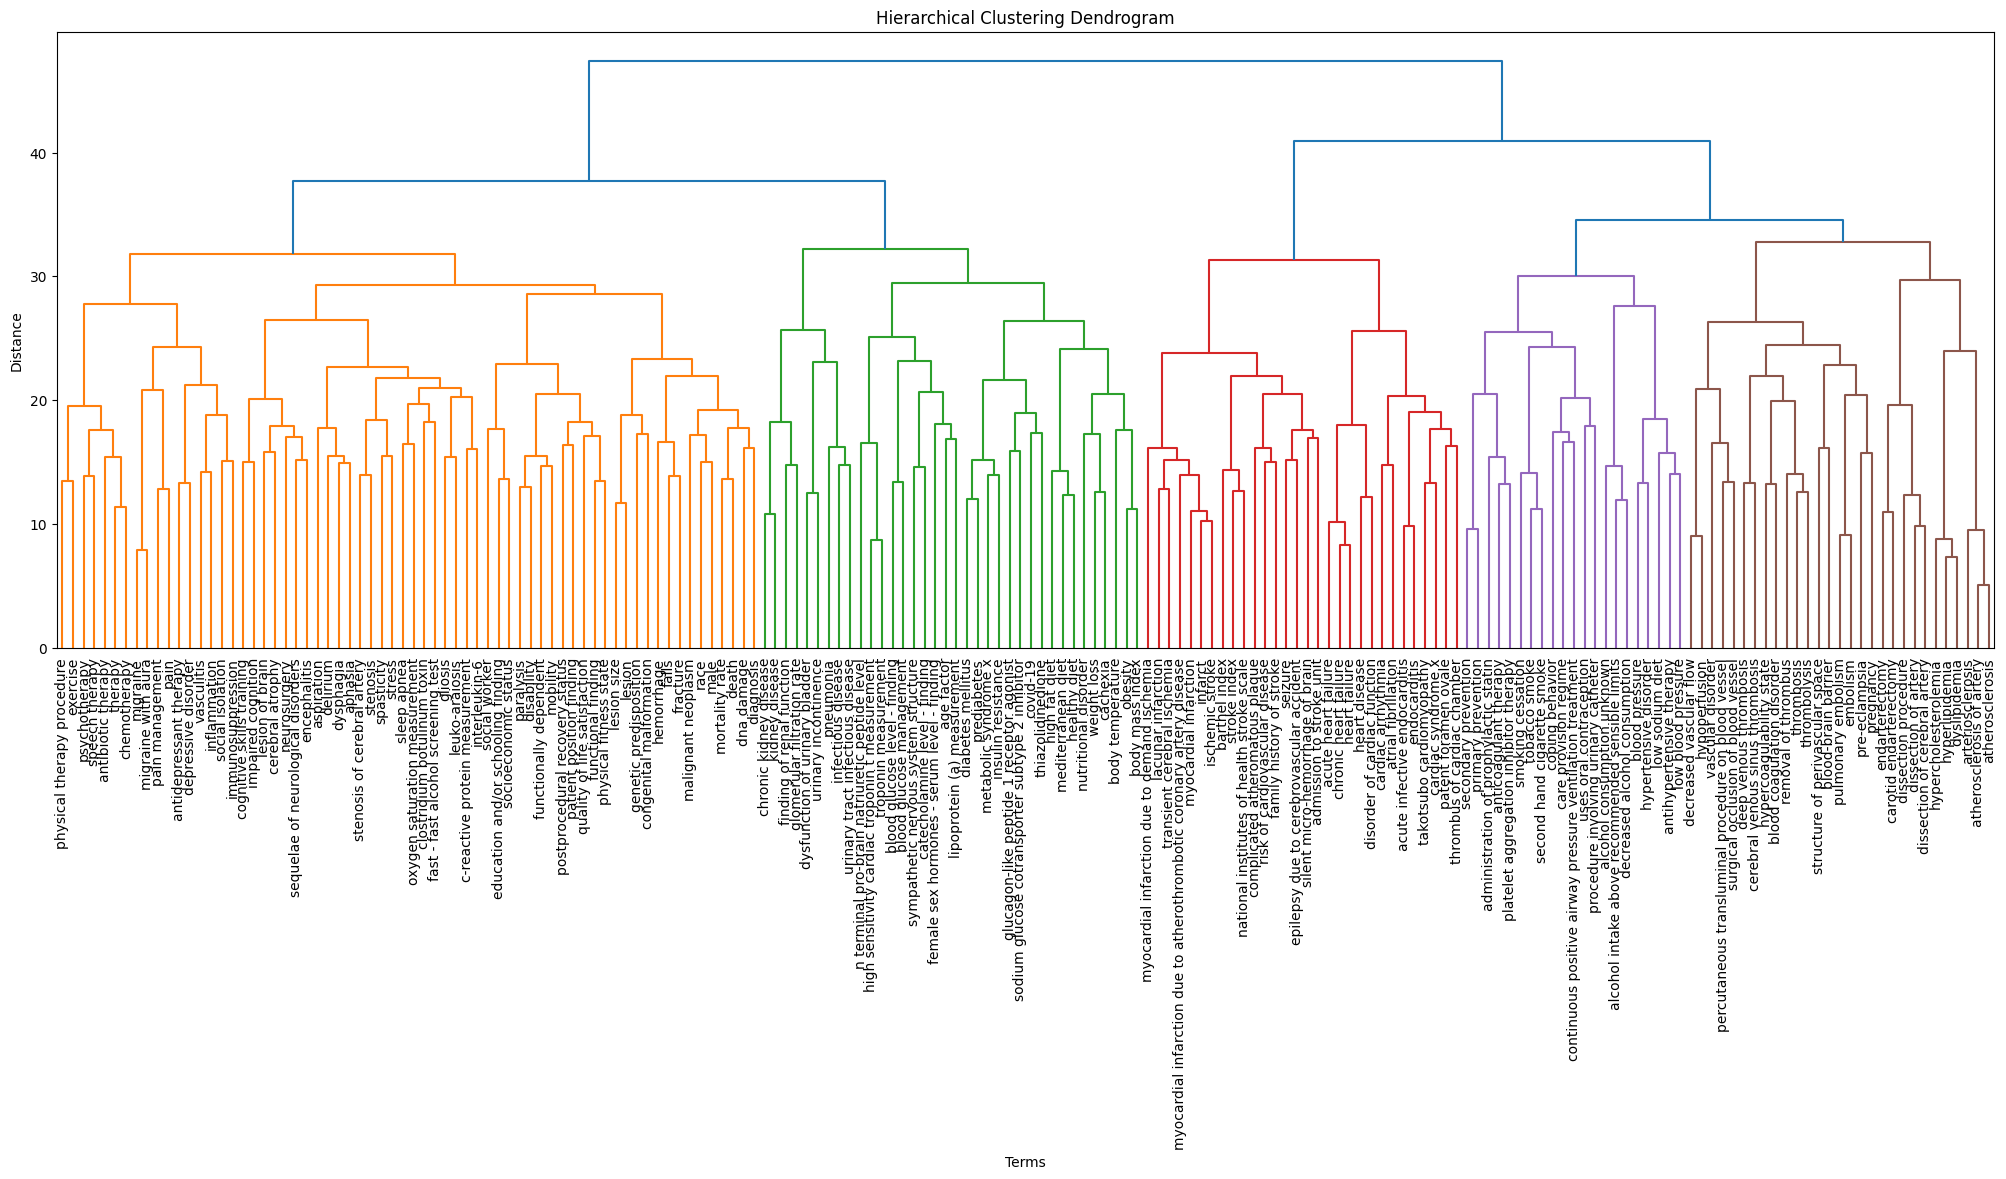

In [105]:
plt.figure(figsize=(25, 8))
dendrogram(linkage_matrix, labels=list(embeddings.keys()), leaf_rotation=90, leaf_font_size=10)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Terms")
plt.ylabel("Distance")

In [106]:
cluster_model = AgglomerativeClustering(n_clusters=None, distance_threshold=30) #19
clusters = cluster_model.fit_predict(embedding_matrix)

term_clusters = dict(zip(list(embeddings.keys()), clusters))
print("Clusters:", term_clusters)

Clusters: {'barthel index': 8, 'arteriosclerosis': 0, 'c-reactive protein measurement': 2, 'high sensitivity cardiac troponin t measurement': 1, 'heart disease': 7, 'dysphagia': 2, 'seizure': 8, 'lesion size': 2, 'percutaneous transluminal procedure on blood vessel': 5, 'chronic kidney disease': 6, 'sympathetic nervous system structure': 1, 'neurosurgery': 2, 'lesion': 2, 'complicated atheromatous plaque': 8, 'deep venous thrombosis': 5, 'obesity': 1, 'mortality rate': 2, 'antibiotic therapy': 3, 'acute heart failure': 7, 'physical therapy procedure': 3, 'blood glucose level - finding': 1, 'antidepressant therapy': 3, 'stenosis of cerebral artery': 2, 'covid-19': 1, 'patent foramen ovale': 7, 'care provision regime': 9, 'catecholamine level - finding': 1, 'paralysis': 2, 'silent micro-hemorrhage of brain': 8, 'dna damage': 2, 'thrombus of cardiac chamber': 7, 'glucagon-like peptide 1 receptor agonist': 1, 'risk of cardiovascular disease': 8, 'stenosis': 2, 'blood glucose management': 1